In [1]:
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch.nn as nn
import time
import copy
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_log_error

In [99]:
PATH = "./saved_model.pth"

In [123]:
# headers=['Tweet Id','username','timestamp', 'followers','friends','retweets','favorites', 'entities','sentiment','mentions','hashtags','urls']

INPUT_DIR='./training_data_v2.csv'
train_df = pd.read_csv(f'{INPUT_DIR}', sep=',')
train_df=train_df.replace(np.nan,0)

INPUT_DIR= './validation_data_v2.csv'
valid_df = pd.read_csv(f'{INPUT_DIR}', sep=',')
valid_df = valid_df.replace(np.nan,0)

INPUT_DIR='./test_data_v2.csv'
test_df = pd.read_csv(f'{INPUT_DIR}', sep=',')
test_df = test_df.replace(np.nan,0)


# Test Code : Train data 
number_of_col = len(train_df.columns)
number_of_row = len(train_df)
train_df.head(5)
print("number_of_col: ", number_of_col)
print("number_of_row: ", number_of_row)

number_of_col:  40
number_of_row:  1300207


In [3]:
# Test Code : Train data 
train_df.head(5)

,followers,friends,favorites,friends_favorites,followers_favorites,followers_favorites_friends,followers_zTransformation,friends_zTransformation,favorites_zTransformation,friends_favorites_zTransformation,...,hour_ce,day_ce,week_of_month_ce,senti_pos_te,senti_neg_te,weekday_te,hour_te,day_te,week_of_month_te,retweets
0,110,342,0,0,0,0,-0.120229,-0.164850,-0.069161,-0.017861,...,48621,43723,279535,37.004128,48.555542,36.043583,46.653622,35.377441,34.443142,0
1,364,411,0,0,0,0,-0.120122,-0.161276,-0.069161,-0.017861,...,65844,41160,131491,37.004128,46.482170,39.928677,27.654570,31.757542,32.218277,0
2,110,167,0,0,0,0,-0.120229,-0.173916,-0.069161,-0.017861,...,69965,43723,279535,36.522129,31.723640,36.566437,32.968044,37.284245,35.013035,0
3,9555393,391,46,17986,439548078,171863298498,3.908055,-0.162312,-0.042321,-0.017494,...,67282,45848,305971,33.643620,32.631733,36.754681,36.272175,35.521835,33.718510,17
4,7036,1078,1,1078,7036,7584808,-0.117310,-0.126723,-0.068578,-0.017839,...,45686,42289,272893,33.643620,32.631733,32.745228,29.310396,36.038578,45.191353,1


In [124]:
# Normalization 
def norm(data_x):
    scaler_x = StandardScaler(copy=True)
    scaler_x.fit(data_x)
    data_x = scaler_x.transform(data_x)
    return data_x,scaler_x

In [125]:
train_lst= np.zeros(shape=(len(train_df),number_of_col))
val_lst= np.zeros(shape=(len(valid_df),number_of_col))
test_lst= np.zeros(shape=(len(test_df),number_of_col))

for i in range(len(train_df.columns)):
    col=train_df[train_df.columns[i]].to_numpy()
    norm_col,scaler_x=norm(col.reshape(-1,1))
    train_lst[:,i]=norm_col.reshape(1,-1)

    val_col=valid_df[valid_df.columns[i]].to_numpy()
    norm_val_col=scaler_x.transform(val_col.reshape(-1,1))
    val_lst[:,i]=norm_val_col.reshape(1,-1)

    test_col=test_df[test_df.columns[i]].to_numpy()
    norm_test_col=scaler_x.transform(test_col.reshape(-1,1))
    test_lst[:,i]=norm_test_col.reshape(1,-1)
    # input_df[c]=norm_col

norm_train_df=pd.DataFrame(train_lst,columns=train_df.columns)
norm_valid_df=pd.DataFrame(val_lst,columns=train_df.columns)
norm_test_df=pd.DataFrame(test_lst,columns=train_df.columns)
    # print(norm_col)

In [126]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, df):
        'Initialization'
        self.labels = df["retweets"].to_numpy()
        self.features = df.drop(["retweets"],1).to_numpy()
        # print(self.features)

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.features)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Load data and get label
        X = self.features[index]
        y = self.labels[index]
        return X, y

In [134]:
train_dataset = Dataset(norm_train_df)
valid_dataset = Dataset(norm_valid_df)
test_dataset = Dataset(norm_test_df)
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=128,shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,batch_size=128,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=128,shuffle=True)

# Model Train Net1 : 

## Result : 
Oscillation 
## Model name :  
Net1
## Model Parameter : 

- Number of layers : 3 
- Each layers : 2048,128,64
- Loass : MSE
- Optimizer : Adam 
- Dropout : 0.5 
- Structure :       
                  nn.Linear(input,2048),
                  nn.ReLU(),
                  nn.Dropout(0.5)
                  nn.Linear(2048,128),
                  nn.ReLU(),
                  nn.Dropout(0.5)
                  nn.Linear(128,64),
                  nn.ReLU(),
                  nn.Dropout(0.5)

In [25]:
import torch.nn as nn
# model definition
class Net1(nn.Module):
    # define model elements
    def __init__(self, n_inputs,channel_list):
        super(TANH, self).__init__()
        #input and hidden layers
        self.layers = nn.ModuleList()
        for i in range(len(channel_list)-2):
          self.layers.append(
              nn.Sequential(
                  nn.Linear(channel_list[i],channel_list[i+1]),
                  nn.ReLU(),
                  nn.Dropout(0.5)
              )                
          )

        #output layer
        self.output = nn.Linear(channel_list[len(channel_list)-2], 1)
 
    # forward propagate input
    def forward(self, X):
      #hidden layers
      for layer in self.layers:
        X = layer(X)
      #output layer
      X = self.output(X)
      return X

In [32]:
input_size= number_of_col
size_hidden= 128
output_size=1
channel_list=[number_of_col-1,2048,128,64,1]
model = Net1(input_size, channel_list)
epochs=5
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [34]:
# Train model 1 Oscillation 
training_loss=[]
validation_loss=[]

for epoch in range(epochs):
    print(epoch,len(train_dataloader))
    running_loss = 0
    model.train()
    
    for x, label in train_dataloader:
        optimizer.zero_grad()
        y=model(x.float())
        loss=criterion(y,label.float().reshape(-1,1))
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Validate on validation dataset
    model.eval()
    running_loss_val=0
    for x_val,label_val in valid_dataloader:
        y_val=model(x_val.float())
        loss_val=criterion(y_val,label_val.float().reshape(-1,1))
        running_loss_val += loss_val.item()

    # Store loss in the list to plot learning curves
    training_loss.append(running_loss/len(train_dataloader))
    validation_loss.append(running_loss_val/len(valid_dataloader))

    # Print evolution of loss every epoch
    print("epoch {}/{}\t traing loss : {}\t validation loss: {}".format(epoch+1,epochs,running_loss/len(train_dataloader),running_loss_val/len(valid_dataloader)))


0 10158
epoch 1/5	 traing loss : 0.36974122826444616	 validation loss: 0.23084189925888876
1 10158
epoch 2/5	 traing loss : 0.6156010765727963	 validation loss: 0.20358064213219285
2 10158
epoch 3/5	 traing loss : 0.36219934200952864	 validation loss: 0.25244287759836953
3 10158
epoch 4/5	 traing loss : 0.29398822273714925	 validation loss: 0.16507265199514398
4 10158
epoch 5/5	 traing loss : 0.35127029478670796	 validation loss: 0.2577263164165532


# Model Train Net0 : 

## Result : 
Oscillation ; Slow ; Decrease from 0.82 ; 
## Model name :  
Net0
## Model Parameter : 

- Number of layers : 2
- Each layers : 2048,128
- Loass : MSE
- Optimizer : Adam 
- Dropout : 0.5
- Last Activation : sigmoid()
- Batch Normalization : No 
- Structure :       
                  nn.Linear(input,2048),
                  nn.ReLU(),
                  nn.Dropout(0.5)
                  nn.Linear(2048,128),
                  nn.ReLU(),
                  nn.Dropout(0.5)
                  nn.sigmoid()
     

In [101]:
# Net0 - 2 layers , no batch normalization 
class Net0(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden1 = torch.nn.Linear(input_size, 2048)
        self.hidden2 = torch.nn.Linear(2048, 128)
        # Output layer, 10 units - one for each digit
        self.output = torch.nn.Linear(128, output_size)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = torch.nn.Sigmoid()
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden1(x) 
        x = self.relu(x)
        x = self.dropout(x)
        x = self.hidden2(x) 
        x = self.relu(x)
        x = self.dropout(x)
        x = self.sigmoid(x)
        x = self.output(x)
        return x

In [102]:
input_size= number_of_col-1
size_hidden= 128
output_size=1
model = Net0(input_size, 1)
epochs=20
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model 1 
training_loss=[]
validation_loss=[]

for epoch in range(epochs):
    print(epoch,len(train_dataloader))
    running_loss = 0
    model.train()
    
    for x, label in train_dataloader:
        optimizer.zero_grad()
        y=model(x.float())
        loss=criterion(y,label.float().reshape(-1,1))
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Validate on validation dataset
    model.eval()
    running_loss_val=0
    for x_val,label_val in valid_dataloader:
        y_val=model(x_val.float())
        loss_val=criterion(y_val,label_val.float().reshape(-1,1))
        running_loss_val += loss_val.item()

    # Store loss in the list to plot learning curves
    training_loss.append(running_loss/len(train_dataloader))
    validation_loss.append(running_loss_val/len(valid_dataloader))

    # Print evolution of loss every epoch
    print("epoch {}/{}\t traing loss : {}\t validation loss: {}".format(epoch+1,epochs,running_loss/len(train_dataloader),running_loss_val/len(valid_dataloader)))


0 10158
epoch 1/20	 traing loss : 0.8209843215799733	 validation loss: 0.5170543969322402
1 10158
epoch 2/20	 traing loss : 0.7366161965925735	 validation loss: 0.47449952148700847
2 10158
epoch 3/20	 traing loss : 0.7168907307514223	 validation loss: 0.45437853302066256
3 10158
epoch 4/20	 traing loss : 0.7003032623665263	 validation loss: 0.44663637926152067
4 10158
epoch 5/20	 traing loss : 0.6874393123101358	 validation loss: 0.4266848735384446
5 10158
epoch 6/20	 traing loss : 0.6816035547873233	 validation loss: 0.4022314525461834
6 10158
epoch 7/20	 traing loss : 0.6686971543772584	 validation loss: 0.4282702371725457
7 10158
epoch 8/20	 traing loss : 0.6893400524334083	 validation loss: 0.4285061529770848
8 10158
epoch 9/20	 traing loss : 0.7031506380817463	 validation loss: 0.42585526688437075
9 10158
epoch 10/20	 traing loss : 0.6907869935303582	 validation loss: 0.45279141773498005
10 10158
epoch 11/20	 traing loss : 0.725780940047073	 validation loss: 0.48309341758016466
11

KeyboardInterrupt: 

# Model Train Net2 : 

## Result : 
No Oscillation ; Slow ; Decrease from 0.87 ; 
## Model name :  
Net2
## Model Parameter : 

- Number of layers : 4
- Each layers : 2048,512,256,128
- Loass : MSE
- Optimizer : Adam 
- Dropout : 0.5
- Last Activation : sigmoid()
- Batch Normalization : No 
- Structure :     
                  nn.Linear(input,2048),
                  nn.ReLU(),
                  nn.Dropout(0.5)
                  nn.Linear(2048,512),
                  nn.ReLU(),
                  nn.Dropout(0.5)
                  nn.Linear(512,256),
                  nn.ReLU(),
                  nn.Dropout(0.5)
                  nn.Linear(256,128),
                  nn.ReLU(),
                  nn.Dropout(0.5)
                  nn.sigmoid()
     

In [39]:
# Net2 model FOUR hidden layers , decrese , but slow that network2 
class Net2(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden1 = torch.nn.Linear(input_size, 2048)
        self.hidden2 = torch.nn.Linear(2048, 512)
        self.hidden3 = torch.nn.Linear(512, 256)
        self.hidden4 = torch.nn.Linear(256, 128)
        # Output layer, 10 units - one for each digit
        self.output = torch.nn.Linear(128, output_size)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax(dim=1)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=0.5)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.hidden2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.hidden3(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.hidden4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.sigmoid(x)
        x = self.output(x)
        # x = self.softmax(x)
        
        return x

In [43]:
input_size= number_of_col-1
size_hidden= 128
output_size=1
channel_list=[number_of_col-1,128,128,64,1]
model = Net2(input_size, 1)
epochs=5
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:

training_loss=[]
validation_loss=[]

for epoch in range(epochs):
    print(epoch,len(train_dataloader))
    running_loss = 0
    model.train()
    
    for x, label in train_dataloader:
        optimizer.zero_grad()
        y=model(x.float())
        loss=criterion(y,label.float().reshape(-1,1))
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Validate on validation dataset
    model.eval()
    running_loss_val=0
    for x_val,label_val in valid_dataloader:
        y_val=model(x_val.float())
        loss_val=criterion(y_val,label_val.float().reshape(-1,1))
        running_loss_val += loss_val.item()

    # Store loss in the list to plot learning curves
    training_loss.append(running_loss/len(train_dataloader))
    validation_loss.append(running_loss_val/len(valid_dataloader))

    # Print evolution of loss every epoch
    print("epoch {}/{}\t traing loss : {}\t validation loss: {}".format(epoch+1,epochs,running_loss/len(train_dataloader),running_loss_val/len(valid_dataloader)))


0 10158
epoch 1/5	 traing loss : 0.8771515294771401	 validation loss: 1.2487792572715568
1 10158
epoch 2/5	 traing loss : 0.8347511849881207	 validation loss: 0.7637267901077168
2 10158
epoch 3/5	 traing loss : 0.8088140548282047	 validation loss: 0.7134696470871933
3 10158
epoch 4/5	 traing loss : 0.7963440546027045	 validation loss: 0.6238795657380783
4 10158
epoch 5/5	 traing loss : 0.7900380790708533	 validation loss: 0.6451338381705567


# Model Train Net3 : 

## Good Result : 
Good; No Oscillation ; Fast ; Decrease from 0.35 ; 
## Model name :  
Net3
## Model Parameter : 

- Number of hidden layers : 3
- Each layers : 2048,512,128
- Loass : MSE
- Optimizer : Adam 
- Dropout : 0
- Last Activation : Sigmoid
- Batch Normalization : No
- Structure :     
                  nn.Linear(input,2048),
                  nn.ReLU(),
                  nn.Dropout(0.5)
                  nn.Linear(2048,512),
                  nn.ReLU(),
                  nn.Dropout(0.5)
                  nn.Linear(512,128),
                  nn.ReLU(),
                  nn.Sigmoid(),
                 

In [78]:

class Net3(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        
        # Inputs to hidden layer linear transformation
        self.hidden1 = torch.nn.Linear(input_size, 2048)
        self.relu = torch.nn.ReLU()
        self.hidden2 = torch.nn.Linear(2048, 512)
        self.relu = torch.nn.ReLU()
        self.hidden3 = torch.nn.Linear(512, 128)
        self.relu = torch.nn.ReLU()
        self.output = torch.nn.Linear(128, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = nn.Sigmoid()
        x = self.output(x)
        
        return x

In [79]:
input_size= number_of_col-1
size_hidden= 128
output_size=1
model = Net3(input_size, 1)
epochs=5
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [80]:
training_loss=[]
validation_loss=[]

for epoch in range(epochs):
    print(epoch,len(train_dataloader))
    running_loss = 0
    model.train()
    
    for x, label in train_dataloader:
        optimizer.zero_grad()
        y=model(x.float())
        loss=criterion(y,label.float().reshape(-1,1))
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

    # Validate on validation dataset
    model.eval()
    running_loss_val=0
    for x_val,label_val in valid_dataloader:
        y_val=model(x_val.float())
        loss_val=criterion(y_val,label_val.float().reshape(-1,1))
        running_loss_val += loss_val.item()

    # Store loss in the list to plot learning curves
    training_loss.append(running_loss/len(train_dataloader))
    validation_loss.append(running_loss_val/len(valid_dataloader))

    # Print evolution of loss every epoch
    print("epoch {}/{}\t traing loss : {}\t validation loss: {}".format(epoch+1,epochs,running_loss/len(train_dataloader),running_loss_val/len(valid_dataloader)))


0 10158
epoch 1/5	 traing loss : 0.35085593272824855	 validation loss: 3.9435692515903384
1 10158
epoch 2/5	 traing loss : 0.33997039181632943	 validation loss: 1.785681372185784
2 10158
epoch 3/5	 traing loss : 0.3578981831269494	 validation loss: 0.7380500144205925
3 10158
epoch 4/5	 traing loss : 0.23477817855294567	 validation loss: 1.1190144745891966
4 10158
epoch 5/5	 traing loss : 0.20690901891491786	 validation loss: 0.4849992956962681


# Model Net4 : No droupout + sigmoid  

## Good Result : 
Good; No Oscillation ; Slow ; Decrease from 0.65; 
## Model name :  
Net4
## Model Parameter : 

- Number of hidden layers : 3
- Each layers : 2048,512,128
- Loass : MSE
- Optimizer : Adam 
- Dropout : No
- Last Activation :sigmoid
- Batch Normalization : Yes
- Structure : 
                  nn.Linear(input,2048),
                  nn.BatchNorm1d(2048)
                  nn.ReLU(),   
                  nn.Linear(2048,512),
                  nn.BatchNorm1d(512)
                  nn.ReLU(),
                  nn.Linear(512,128),
                  nn.BatchNorm1d(128)
                  nn.ReLU(),
                  nn.Sigmoid()
                 

In [86]:
class Net4(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.hidden1 = nn.Linear(input_size,2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.hidden2 = nn.Linear(2048,512)
        self.bn2 = nn.BatchNorm1d(512)
        self.hidden3 = nn.Linear(512,128)
        self.bn3 = nn.BatchNorm1d(128)
        self.output = nn.Linear(128, output_size)
        
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self,x):  # Input is a 1D tensor
        x = self.relu(self.bn1(self.hidden1(x)))
        x = self.relu(self.bn2(self.hidden2(x)))
        x = self.relu(self.bn3(self.hidden3(x)))
        x = self.output(self.sigmoid(x))
        return x

In [91]:
input_size= number_of_col-1
output_size=1
model = Net4(input_size, 1)
epochs=20
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [92]:
# Train model 2 Best model (Based on network , add batch normalization)
training_loss=[]
validation_loss=[]

for epoch in range(epochs):
    print(epoch,len(train_dataloader))
    running_loss = 0
    model.train()
    
    for x, label in train_dataloader:
        optimizer.zero_grad()
        y=model(x.float())
        loss=criterion(y,label.float().reshape(-1,1))
        running_loss += loss.item()
        # print(running_loss)
        # accuracy=calculate_accuracy(y,label.float().reshape(-1,1))
        # running_accuracy += accuracy.item()

        loss.backward()
        optimizer.step()

    # Validate on validation dataset
    model.eval()
    running_loss_val=0
    for x_val,label_val in valid_dataloader:
        y_val=model(x_val.float())
        loss_val=criterion(y_val,label_val.float().reshape(-1,1))
        running_loss_val += loss_val.item()

    # Store loss in the list to plot learning curves
    training_loss.append(running_loss/len(train_dataloader))
    validation_loss.append(running_loss_val/len(valid_dataloader))

    # Print evolution of loss every epoch
    print("epoch {}/{}\t traing loss : {}\t validation loss: {}".format(epoch+1,epochs,running_loss/len(train_dataloader),running_loss_val/len(valid_dataloader)))


0 10158
epoch 1/20	 traing loss : 0.6519887092416397	 validation loss: 0.35313528104035274
1 10158
epoch 2/20	 traing loss : 0.5127373837799442	 validation loss: 0.3330982380599824
2 10158
epoch 3/20	 traing loss : 0.46913746594970573	 validation loss: 0.2894495785666903
3 10158
epoch 4/20	 traing loss : 0.4446710851055725	 validation loss: 0.2630509936345499
4 10158
epoch 5/20	 traing loss : 0.4179223859998988	 validation loss: 0.21745016016721658
5 10158
epoch 6/20	 traing loss : 0.41365394289746743	 validation loss: 0.2548909946175443
6 10158
epoch 7/20	 traing loss : 0.39527301082971844	 validation loss: 0.222926383564188
7 10158
epoch 8/20	 traing loss : 0.38346410872792264	 validation loss: 0.20337741527812775
8 10158
epoch 9/20	 traing loss : 0.37555788285278213	 validation loss: 0.29020490903557566
9 10158
epoch 10/20	 traing loss : 0.36905568335361866	 validation loss: 0.226553540556313
10 10158
epoch 11/20	 traing loss : 0.36381985133634237	 validation loss: 0.184531590624432

# Model Train Net5 :  Best !  No Dropout ; Relu

## Best Result : 
Good; No Oscillation ; Fast ; Decrease from 0.45; 
## Model name :  
Net5
## Model Parameter : 

- Number of hidden layers : 3
- Each layers : 2048,512,128
- Loass : MSE
- Optimizer : Adam 
- Dropout : No
- Last Activation :relu
- Batch Normalization : Yes
- Structure : 
                  nn.Linear(input,2048),
                  nn.BatchNorm1d(2048)
                  nn.ReLU(),   
                  nn.Linear(2048,512),
                  nn.BatchNorm1d(512)
                  nn.ReLU(),
                  nn.Linear(512,128),
                  nn.BatchNorm1d(128)
                  nn.ReLU(),
                  nn.ReLU(),
                 

In [105]:
# Train model 6 based on network1 (last act to relu)
class Net5(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.hidden1 = nn.Linear(input_size,2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.hidden2 = nn.Linear(2048,512)
        self.bn2 = nn.BatchNorm1d(512)
        self.hidden3 = nn.Linear(512,128)
        self.bn3 = nn.BatchNorm1d(128)
        self.output = nn.Linear(128, output_size)
        
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self,x):  # Input is a 1D tensor
        x = self.relu(self.bn1(self.hidden1(x)))
        x = self.relu(self.bn2(self.hidden2(x)))
        x = self.relu(self.bn3(self.hidden3(x)))
        x = self.output(self.relu(x))
        return x

In [106]:
input_size= number_of_col-1
output_size=1
model = Net5(input_size, 1)
epochs=40
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train model 8 Decrease but slow than network1 (Based on network , add batch normalization+dropout)
training_loss=[]
validation_loss=[]

for epoch in range(epochs):
    print(epoch,len(train_dataloader))
    running_loss = 0
    model.train()
    
    for x, label in train_dataloader:
        optimizer.zero_grad()
        y=model(x.float())
        loss=criterion(y,label.float().reshape(-1,1))
        running_loss += loss.item()
        # print(running_loss)
        # accuracy=calculate_accuracy(y,label.float().reshape(-1,1))
        # running_accuracy += accuracy.item()

        loss.backward()
        optimizer.step()

    # Validate on validation dataset
    model.eval() 
    running_loss_val=0
    for x_val,label_val in valid_dataloader:
        y_val=model(x_val.float())
        loss_val=criterion(y_val,label_val.float().reshape(-1,1))
        running_loss_val += loss_val.item()

    # Store loss in the list to plot learning curves
    training_loss.append(running_loss/len(train_dataloader))
    validation_loss.append(running_loss_val/len(valid_dataloader))

    # Print evolution of loss every epoch
    print("epoch {}/{}\t traing loss : {}\t validation loss: {}".format(epoch+1,epochs,running_loss/len(train_dataloader),running_loss_val/len(valid_dataloader)))


0 10158
epoch 1/40	 traing loss : 0.45959740254776477	 validation loss: 1.5801160031782495
1 10158
epoch 2/40	 traing loss : 0.3606043070781925	 validation loss: 0.2432074875914521
2 10158
epoch 3/40	 traing loss : 0.34136310745283965	 validation loss: 0.18061302800275075
3 10158
epoch 4/40	 traing loss : 0.31812251912860656	 validation loss: 1.1683349818184918
4 10158
epoch 5/40	 traing loss : 0.29419716993674533	 validation loss: 0.3465436754506356
5 10158
epoch 6/40	 traing loss : 0.26791360536818054	 validation loss: 0.29350163061828394
6 10158
epoch 7/40	 traing loss : 0.2746251691771819	 validation loss: 0.40624648576855016
7 10158
epoch 8/40	 traing loss : 0.27541424051663566	 validation loss: 0.7010690172124237
8 10158
epoch 9/40	 traing loss : 0.25386797179092346	 validation loss: 0.26452218193044685
9 10158
epoch 10/40	 traing loss : 0.2061884867798324	 validation loss: 0.283232503929057
10 10158
epoch 11/40	 traing loss : 0.21130365736419576	 validation loss: 0.7817513636857

KeyboardInterrupt: 

# Model Train Net6 :  Compare last actvation fun : Sigmoid , dropout 0.25

## Good Result : 
Good; No Oscillation ; Slow ; Decrease from 0.77; 
## Model name :  
Net6
## Model Parameter : 

- Number of hidden layers : 3
- Each layers : 2048,512,128
- Loass : MSE
- Optimizer : Adam 
- Dropout : Yes 0.25
- Last Activation :nn.Sigmoid()
- Batch Normalization : Yes
- Structure : 
                  nn.Linear(input,2048),
                  nn.BatchNorm1d(2048)
                  nn.Dropout(0.25),
                  nn.ReLU(),   
                  nn.Linear(2048,512),
                  nn.BatchNorm1d(512)
                  nn.Dropout(0.25),
                  nn.ReLU(),
                  nn.Linear(512,128),
                  nn.BatchNorm1d(128),
                  nn.Dropout(0.25),
                  nn.ReLU(),
                  nn.Sigmoid(),
                 

In [93]:

class Net6(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.hidden1 = nn.Linear(input_size,2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(0.25)
        self.hidden2 = nn.Linear(2048,512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.25)
        self.hidden3 = nn.Linear(512,128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.25)
        self.output = nn.Linear(128, output_size)
        
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self,x):  # Input is a 1D tensor
        x = self.relu(self.dropout1(self.bn1(self.hidden1(x))))
        x = self.relu(self.dropout2(self.bn2(self.hidden2(x))))
        x = self.relu(self.dropout3(self.bn3(self.hidden3(x))))
        x = self.output(self.sigmoid(x))
        return x

In [97]:
input_size= number_of_col-1
output_size=1
model = Net6(input_size, 1)
epochs=40
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [98]:

training_loss=[]
validation_loss=[]

for epoch in range(epochs):
    print(epoch,len(train_dataloader))
    running_loss = 0
    model.train()
    
    for x, label in train_dataloader:
        optimizer.zero_grad()
        y=model(x.float())
        loss=criterion(y,label.float().reshape(-1,1))
        running_loss += loss.item()
        # print(running_loss)
        # accuracy=calculate_accuracy(y,label.float().reshape(-1,1))
        # running_accuracy += accuracy.item()

        loss.backward()
        optimizer.step()

    # Validate on validation dataset
    model.eval() 
    running_loss_val=0
    for x_val,label_val in valid_dataloader:
        y_val=model(x_val.float())
        loss_val=criterion(y_val,label_val.float().reshape(-1,1))
        running_loss_val += loss_val.item()

    # Store loss in the list to plot learning curves
    training_loss.append(running_loss/len(train_dataloader))
    validation_loss.append(running_loss_val/len(valid_dataloader))

    # Print evolution of loss every epoch
    print("epoch {}/{}\t traing loss : {}\t validation loss: {}".format(epoch+1,epochs,running_loss/len(train_dataloader),running_loss_val/len(valid_dataloader)))


0 10158
epoch 1/40	 traing loss : 0.7718691598979448	 validation loss: 0.4396085640129212
1 10158
epoch 2/40	 traing loss : 0.6736815789946232	 validation loss: 0.38692490285437425
2 10158
epoch 3/40	 traing loss : 0.6206768536002751	 validation loss: 0.3965159830375874
3 10158
epoch 4/40	 traing loss : 0.5776777088887007	 validation loss: 0.3353800841979932
4 10158
epoch 5/40	 traing loss : 0.5503472220268596	 validation loss: 0.2949366531227181
5 10158
epoch 6/40	 traing loss : 0.5224788878794928	 validation loss: 0.30007643687602387
6 10158
epoch 7/40	 traing loss : 0.5082947287927783	 validation loss: 0.2856350668783091
7 10158
epoch 8/40	 traing loss : 0.49351099263204407	 validation loss: 0.300995232804609
8 10158
epoch 9/40	 traing loss : 0.47908333203028086	 validation loss: 0.27709740262465293
9 10158
epoch 10/40	 traing loss : 0.46761063566904676	 validation loss: 0.28473647887883086
10 10158
epoch 11/40	 traing loss : 0.45566203872973754	 validation loss: 0.25012427940299764

KeyboardInterrupt: 

# Model Train Net7: 

## Good Result : 
Oscillation ;Fasr ; Decrease from 0.50 - 0.28 - 0.33 - 0.22 - 0.26; 
## Model name :  
network
## Model Parameter : 

- Number of hidden layers : 3
- Each layers : 2048,512,128
- Loass : MSE
- Optimizer : Adam 
- Dropout : Yes 0.3 
- Last Activation :  nn.Relu()
- Batch Normalization : Yes
- Structure : 
                  nn.Linear(input,2048),
                  nn.BatchNorm1d(2048),
                  nn.ReLU(), 
                  nn.Dropout(0.3),  
                  nn.Linear(2048,512),
                  nn.BatchNorm1d(512),
                  nn.ReLU(),
                  nn.Dropout(0.3),
                  nn.Linear(512,128),
                  nn.BatchNorm1d(128),
                  nn.ReLU(),
                  nn.Dropout(0.3),
                 
                  nn.ReLU(),
                 

In [9]:
# Train model 7  : oscilate, but fast decrease , Based on network22 ,  dropout to 0.3
class Net7(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.hidden1 = nn.Linear(input_size,2048)
        self.bn1 = nn.BatchNorm1d(2048)
        self.dropout1 = nn.Dropout(0.3)
        self.hidden2 = nn.Linear(2048,512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.3)
        self.hidden3 = nn.Linear(512,128)
        self.bn3 = nn.BatchNorm1d(128)
        self.dropout3 = nn.Dropout(0.3)
        self.output = nn.Linear(128, output_size)
        
        self.relu = torch.nn.ReLU()
#         self.sigmoid = torch.nn.Sigmoid()

    def forward(self,x):  # Input is a 1D tensor
        x = self.dropout1(self.relu(self.bn1(self.hidden1(x))))
        x = self.dropout2(self.relu(self.bn2(self.hidden2(x))))
        x = self.dropout3(self.relu(self.bn3(self.hidden3(x))))
        x = self.output(self.relu(x))
        return x
    
def initialise_weights(self):
    for m in self.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
            nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')

In [35]:
def train_model(model, train_dataloader, valid_dataloader): 
    since = time.time() 
    best_model_wts = copy.deepcopy(model.state_dict()) 
    epochs= 40
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    lowest_loss = 1.0
    training_loss=[]
    validation_loss=[]
    
     
    for epoch in range(epochs): 
        running_loss_val=0
        running_loss = 0.0
        # Each epoch has a training and validation phase 
        for phase in ['train', 'test']: 
            if phase == 'train': 
                model.train()  # Set model to training mode 
                
                for x, label in tqdm(train_dataloader):
                    x = x.to(device)
                    label = label.to(device)
                    optimizer.zero_grad()
                    y=model(x.float())
#                     loss = mean_squared_log_error(y.cpu().detach().numpy().reshape(-1, 1), label.cpu().detach().numpy().reshape(-1, 1))
                    loss=criterion(y,label.float().reshape(-1,1))
                    running_loss += loss.item()

                    loss.backward()
                    optimizer.step()
            else: 
                model.eval()   # Set model to evaluate mode 
                
                for x_val,label_val in tqdm(valid_dataloader):
                    x_val = x_val.to(device)
                    label_val = label_val.to(device)
                    y_val=model(x_val.float())
                    label_val = label_val.to(device)
#                     loss_val=criterion(y_val,label_val.float().reshape(-1,1))
#                     loss_val = mean_squared_log_error(y_val.cpu().detach().numpy().reshape(-1, 1), label_val.cpu().detach().numpy().reshape(-1, 1))
                    loss_val=criterion(y_val,label_val.float().reshape(-1,1))
                    running_loss_val += loss_val.item()
 
            # deep copy the model 
            if phase == 'test' and running_loss_val < lowest_loss: 
                lowest_loss = running_loss_val
                best_model_wts = copy.deepcopy(model.state_dict()) 
            if phase == 'train': 
                # save model  
                torch.save(model.state_dict(), PATH) 
        
        # Store loss in the list to plot learning curves
        training_loss.append(running_loss/len(train_dataloader))
        validation_loss.append(running_loss_val/len(valid_dataloader))
        print("epoch {}/{}\t traing loss : {}\t validation loss: {}".format(epoch+1,epochs,running_loss/len(train_dataloader),running_loss_val/len(valid_dataloader)))
         
    time_elapsed = time.time() - since 
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 

     
    # load best model weights 
    model.load_state_dict(best_model_wts) 
     
    return training_loss, validation_loss

In [37]:
training_loss = [] 
validation_loss = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size= number_of_col-1
output_size=1
model = Net7(input_size, 1)
model.apply(initialise_weights)
model.to(device)
training_loss, validation_loss = train_model(model, train_dataloader, valid_dataloader)


epoch 1/40	 traing loss : 0.5314232903304231	 validation loss: 0.6566430671582838



epoch 2/40	 traing loss : 0.4187367519694487	 validation loss: 0.41823763617004567



epoch 3/40	 traing loss : 0.34444046965854547	 validation loss: 0.26205027928421415



epoch 4/40	 traing loss : 0.3432885267951297	 validation loss: 0.22888336362602285



epoch 5/40	 traing loss : 0.3338779198257765	 validation loss: 0.2606406329428836



epoch 6/40	 traing loss : 0.3355595997230784	 validation loss: 0.3249156148016167



epoch 7/40	 traing loss : 0.2979164354804427	 validation loss: 0.2605691870583742



epoch 8/40	 traing loss : 0.3037354488445018	 validation loss: 0.2754500461732657



epoch 9/40	 traing loss : 0.352952209290096	 validation loss: 0.2664006193359813



epoch 10/40	 traing loss : 0.3023080698857609	 validation loss: 0.24620132010437432



epoch 11/40	 traing loss : 0.3018506055870485	 validation loss: 0.23024513508387068



epoch 12/40	 traing loss : 0.30947637015943896	 validation loss: 0.23348317290961057



epoch 13/40	 traing loss : 0.29852608118563395	 validation loss: 0.24755691147554212



epoch 14/40	 traing loss : 0.2777178243127203	 validation loss: 0.26649421077349045



epoch 15/40	 traing loss : 0.30771686001127024	 validation loss: 0.24503912373764924



epoch 16/40	 traing loss : 0.27085109717808514	 validation loss: 0.22789478822467815



epoch 17/40	 traing loss : 0.2828188765108291	 validation loss: 0.23923798940739388



epoch 18/40	 traing loss : 0.2911545074279239	 validation loss: 0.23460844739085415



epoch 19/40	 traing loss : 0.3085072051762521	 validation loss: 0.2486047695018947



epoch 20/40	 traing loss : 0.295011198086222	 validation loss: 0.2848167199391219



epoch 21/40	 traing loss : 0.25724831974112256	 validation loss: 0.23971021616126514



epoch 22/40	 traing loss : 0.27141712745167973	 validation loss: 0.25644266113861625



epoch 23/40	 traing loss : 0.2391100098265452	 validation loss: 0.2515603433303557



epoch 24/40	 traing loss : 0.2890558187886447	 validation loss: 0.22472669970549874



epoch 25/40	 traing loss : 0.23743693917470296	 validation loss: 0.29119394719829844



epoch 26/40	 traing loss : 0.24706462930282733	 validation loss: 0.2749049372880309



epoch 27/40	 traing loss : 0.2251709747987104	 validation loss: 0.22167038363214367



epoch 28/40	 traing loss : 0.21550890355070493	 validation loss: 0.22181727507332244



epoch 29/40	 traing loss : 0.25625133391928684	 validation loss: 0.4533979876630107



epoch 30/40	 traing loss : 0.2275335804353025	 validation loss: 0.22167146543481325



epoch 31/40	 traing loss : 0.22489479825629147	 validation loss: 0.2350194534533208



epoch 32/40	 traing loss : 0.27094510806486555	 validation loss: 0.23274061923116027



epoch 33/40	 traing loss : 0.20969392566525985	 validation loss: 0.24308292213467583



epoch 34/40	 traing loss : 0.1916727830746548	 validation loss: 0.23630889539316288



epoch 35/40	 traing loss : 0.22204410374494138	 validation loss: 0.2842170172002933



epoch 36/40	 traing loss : 0.18745106448851498	 validation loss: 0.25115351032226907



epoch 37/40	 traing loss : 0.22142437595381867	 validation loss: 0.24367544204381653



epoch 38/40	 traing loss : 0.2063038847560696	 validation loss: 0.24525465216734227



epoch 39/40	 traing loss : 0.21253006580722783	 validation loss: 0.24073321676549986



epoch 40/40	 traing loss : 0.19612414710006315	 validation loss: 0.2277471160619725
Training complete in 28m 37s


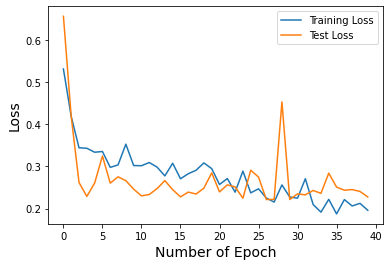

In [38]:
def plot_graph(training_loss, validation_loss):
#     plt.figtext(.5,.9,'Training/Validation losses over {} epochs'.format(epoch), fontsize=15, ha='center')
    plt.plot(training_loss, label = "Training Loss")
    plt.plot(validation_loss, label = 'Test Loss')
    plt.xlabel('Number of Epoch', fontsize = 14)
    plt.ylabel('Loss', fontsize = 14)
    plt.legend()
    
plot_graph(training_loss, validation_loss)

In [105]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [147]:
load_model = True 
 
if load_model: 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
    model = Net7(39, 1)
    model.load_state_dict(torch.load(PATH)) 
    criterion = RMSLELoss()
#     model.eval()

In [148]:
def test(model, test_dataloader): 
    model.to(device)
    model.eval()
    test_loss = 0
    for x_test,label_test in tqdm(test_dataloader):
        x_test = x_test.to(device)
        label_test = label_test.to(device)
        y_test=model(x_test.float())
        loss_test=criterion(y_test,label_test.float().reshape(-1,1))
#         loss_test=mean_squared_log_error(y_test.cpu().detach().numpy().reshape(-1, 1),label_test.cpu().detach().numpy().reshape(-1, 1))
#         loss_test = msle(y_test, label_test.float().reshape(-1,1))
        test_loss += loss_test.item()
#         print(test_loss)

    overall_loss = test_loss/len(test_dataloader)        
    print("-----------------------------")         
    print("Loss of the model: {:.4f}".format(overall_loss)) 
    return overall_loss

In [146]:
test(Net7(input_size, 1), test_dataloader)


-----------------------------
Loss of the model: 0.1559


0.15592424347930217